# Basis embedding (pennylane)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Basis embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.BasisEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import pennylane as qml
from pennylane import numpy as pnp

### Prerequisites

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

## 1) Generating an artificial image of the sky (frequency domain)

In [3]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 4 #20
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 1.37190847e+01+9.5460480e+01j -1.06728505e-02-3.4303274e-03j
  -1.22258775e-02+2.1446493e-02j  3.27534392e-03+8.0854613e-03j]
 [ 4.72873268e+01+1.0596187e+01j  5.19575539e+01+6.5964111e+01j
   9.86193466e+01+4.2990082e+01j -1.25710331e-02+9.7007947e-03j]
 [ 9.15319007e-03+6.2196474e-03j  2.11306978e-02+9.5685199e-03j
  -6.78788545e-03+3.0965744e-02j -3.83862085e-03+2.9439286e-03j]
 [-1.40980100e-02+1.2105641e-02j -1.33065432e-02+1.4948565e-02j
   2.15258729e-03-3.8565216e-03j  9.16195381e-03+5.5254130e-03j]]


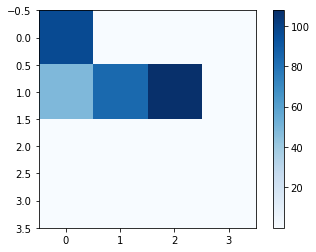

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 211.55469  +215.12508j     28.357924  +11.077677j
   107.65322   +83.10217j   -103.55996  +114.99503j  ]
 [ 133.21117  -102.43086j    -70.70522   +80.87348j
     1.3538643  +1.4831067j   33.316246 +212.68562j  ]
 [-184.11646   -24.052525j    -0.8732028+179.72885j
   -80.25456  +107.90171j    131.06424   +75.85558j  ]
 [-105.851555 +293.30463j     98.09968  +110.13191j
    26.104502 +189.42209j     -5.849226  -21.835896j ]]


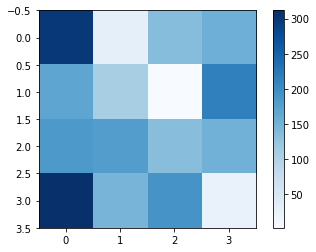

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: ' + str(test_imag))

Reals MSE: 5.9056904e-13
Imaginaries MSE: 4.2062312e-13


C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcpara

(<Figure size 432x504 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x24892535a30>)

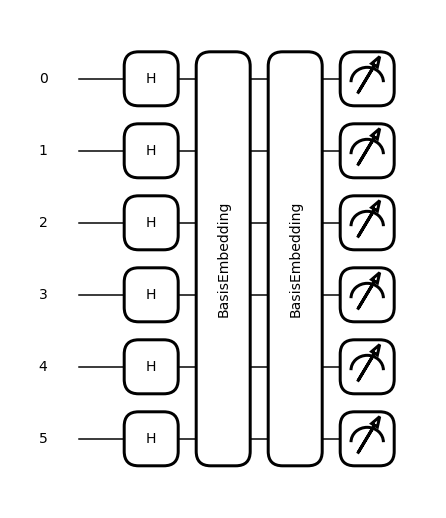

In [8]:
from pennylane.templates.embeddings import BasisEmbedding
# quantum device where you want to run and how many Qubits
dev = qml.device('default.qubit', wires=6)

@qml.qnode(dev)
def circuit(data):
    for i in range(6):
        qml.Hadamard(i)
    for i in range(len(data)):
        BasisEmbedding(features=data[i], wires=range(6),do_queue=True)
    return  qml.state()

data=[[1,0,1,1,1,0],
      [1,0,0,0,0,1]]

circuit(data)

qml.draw_mpl(circuit)(data)

## 3) Data encoding: basis embedding (non-conventional domain)

In [9]:
from pennylane.templates.embeddings import BasisEmbedding

# vectorize input data
data = visibilities.flatten()

# get binary representations of real and imaginary parts
data_reals = []
data_imags = []
for i in range(0, len(data)):
    data_reals.append(float_to_bin_real(data[i].real))
    data_imags.append(float_to_bin_imag(data[i].imag))

# combine binary representations into a single array (reals then imaginaries)
data_binaries = data_reals + data_imags 

# sparse all binary representations strings into single characters
data_binary = []
for i in range(0, len(data_binaries)):
    data_binary.append([*data_binaries[i]])

# make all character-strings integers
inp = []
for i in range(0, len(data_binary)):
    tmp = []
    for j in range(0, len(data_binary[i])):  
        tmp.append(int(data_binary[i][j]))
    inp.append(tmp)

# n bits encoded onto n quibts
wires = range(32) 
print(inp[0])
bas_dev = qml.device('default.qubit', wires) # simulator (MOTIVATION?)

# encoding
@qml.qnode(bas_dev)
def basis_encoding(inp):
    for i in wires:
        qml.Hadamard(i)
    for i in range(len(inp)):
        BasisEmbedding(features=inp[i], wires=wires, do_queue=True)
    return qml.state()

readout = basis_encoding(inp)
print(readout)

[0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


MemoryError: Unable to allocate 64.0 GiB for an array with shape (4294967296,) and data type complex128

In [ ]:
inp[0]

## 4) Applying 2D IFT (fidelity test)

In [ ]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')